In [1]:
import gym
import gym_trading

env = gym.make('trading-v0')
access_token = "XXX"
accountID = "XX"
instrument = "GBPUSD"
additional_pairs = []
input_planets_data = {}
env.initialise_simulator(instrument, additional_pairs, accountID, access_token, input_planets_data, time_frame="1440",
                         oanda=False, size_of_history=4500, ATR=True, SMA=True, RSI=True, BB=False,
                         trade_period=1, train_split=0.4, dummy_period=None)

[2017-08-20 11:39:49,746] Making new env: trading-v0
C:\Users\Henry\Anaconda2\envs\tensorflow\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Can not use swisseph package!
Please evoke .initialise_simulator() method next to complete initialization


# Q Network Using Openai Baselines

In [2]:
env.observation_space

Box(4,)

Thanks to the Folks in the OpenAI team who have created the baselines library. Implementing deep RL models has never been easier. So using the extensive tools that the team have  created, we attempt to build a RL learning agent for the same environment. But this time, we will be using a network of 4 layers.

In [3]:
import gym_trading
import gym
import itertools
import numpy as np
import baselines.common.tf_util as U
from baselines import deepq
from baselines.deepq.replay_buffer import ReplayBuffer
from baselines.common.schedules import LinearSchedule
import tensorflow as tf
from tensorflow.contrib import layers

BATCH_SIZE = 32

#number of neurons in each hidden layer
neurons = [256, 128, 64, 32]


def model(hidden_layers, inpt, num_actions, scope, reuse=False):
    #Network to be used
    with tf.variable_scope(scope, reuse=reuse):
        out = inpt
        
        for hidden in hidden_layers:
            out = layers.fully_connected(out, num_outputs=hidden, activation_fn=tf.nn.tanh)
        
        return layers.fully_connected(out, num_outputs=num_actions, activation_fn = None)


def observe(update_target, train, steps, replaybuff, frequency=500):
    # Either Train the Model or update Target
    reshape = lambda x: np.reshape(x, [BATCH_SIZE, env.observation_space.shape[0]])
    
    if steps> frequency:
        #Training the model using SGD
        obs_t, actions, reward, obs_tp1, dones = replaybuff.sample(BATCH_SIZE)
        
        weights = np.ones(BATCH_SIZE)
        
        obs_t, obs_tp1 = reshape(obs_t), reshape(obs_tp1)
        
        train(obs_t, actions, reward, obs_tp1, dones, weights)
        
    if steps % frequency == 0:
        #Update target network with online network
        update_target()
        
        
        
# Main Learning Loop     
with U.make_session(8):
    
    base_act, base_train, base_update_target, _ = deepq.build_train(
        make_obs_ph= lambda name:U.BatchInput(env.observation_space.shape, name=name),
        q_func=lambda *args,**kwargs: model(neurons, *args, **kwargs),
        num_actions= env.action_space.n,
        optimizer=tf.train.AdamOptimizer(learning_rate=5e-4),
        gamma=0.99 #discount rate
    )
    
    U.initialize()
    base_update_target()
    
    buffer_size = 50000
    
    exploration = LinearSchedule(10000, initial_p =1.0, final_p=0.02)
    replaybuff = ReplayBuffer(buffer_size)
    
    
    obs = np.reshape(env.sim.states[env.sim.current_index - 1], [1, env.observation_space.shape[0]])
    
    episode_reward = []
    
    episode = 1
    solved = False
    
    for steps in itertools.count():
        
        action = base_act(obs, update_eps=exploration.value(steps))[0]
        
        new_obs, reward, done, _ = env._step(action)
        
        replaybuff.add(obs, action, reward, new_obs, float(done))
        
        obs= np.reshape(new_obs, [1, env.observation_space.shape[0]])
        
        observe(base_update_target, base_train, steps, replaybuff)
        
        if done:
            
            print("Episode %s: %s"%(episode, env.portfolio.total_reward))
            print("steps %s"%steps)
            episode_reward.append(env.portfolio.total_reward)
            episode += 1
            
            env._reset(True)
            obs = np.reshape(env.sim.states[env.sim.current_index - 1], [1, env.observation_space.shape[0]])
            
            if np.mean(episode_reward[-51:-1]) >= 500 and episode > 100:
                solved = True
                print("Solved")
                break

Episode 1: -390.2
steps 825


C:\Users\Henry\Anaconda2\envs\tensorflow\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Henry\Anaconda2\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 2: -1626.3
steps 1651
Episode 3: 732.6
steps 2477
Episode 4: 201.7
steps 3303
Episode 5: -346.8
steps 4129
Episode 6: -1924.8
steps 4955
Episode 7: -745.2
steps 5781
Episode 8: -657.6
steps 6607
Episode 9: -2522.2
steps 7433
Episode 10: 1274.6
steps 8259
Episode 11: -1210.8
steps 9085
Episode 12: -1511.8
steps 9911
Episode 13: 1646.4
steps 10737
Episode 14: 398.5
steps 11563
Episode 15: 273.9
steps 12389
Episode 16: -979.9
steps 13215
Episode 17: 1271.3
steps 14041
Episode 18: 661.7
steps 14867
Episode 19: 380.7
steps 15693
Episode 20: 805.3
steps 16519
Episode 21: 634.9
steps 17345
Episode 22: 1104.9
steps 18171
Episode 23: 851.2
steps 18997
Episode 24: 1190.3
steps 19823
Episode 25: 979.3
steps 20649
Episode 26: 631.6
steps 21475
Episode 27: 437.5
steps 22301
Episode 28: 303.8
steps 23127
Episode 29: 767.5
steps 23953
Episode 30: 318.2
steps 24779
Episode 31: 318.0
steps 25605
Episode 32: 884.3
steps 26431
Episode 33: 893.9
steps 27257
Episode 34: 1187.1
steps 28083
Episode 3

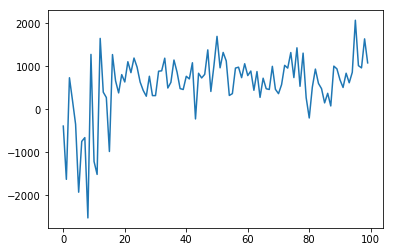

In [4]:
import matplotlib.pyplot as plt
plt.plot(episode_reward)
plt.show()

Pretty messy convergence here. Require more finetuning of statespace. Having said that, using Baselines is a great way to implement deep RL model quickly as most of the necessary tools (Feedforward, training, replaybuffer, target_network) are provided, keeping our code short.

# Behind the Scene

In an attempt to demystify the inner mechanism behind baselines and better appreciate how DQN works, I have recreated the RL model using libraries such as TensorFlow and Numpy. (Borrowed replaybuffer and linearschedule from baselines, They should be relatively easy to implement otherwise). As you can see, it can get pretty tedious having to implement everything on our own. 

The network parameters are same as above.

The theory behind DQN can be found here:https://jaromiru.com/2016/11/07/lets-make-a-dqn-double-learning-and-prioritized-experience-replay/ (Prioritised replay isnt used)

In [5]:
import tensorflow as tf
from tensorflow.contrib import layers
import numpy as np
from baselines.common.schedules import LinearSchedule
from baselines.deepq import ReplayBuffer
import baselines.common.tf_util as U


def huber_loss(error, delta=1.0):
    return tf.where(tf.abs(error)<delta, 0.5 * tf.square(error), delta*(tf.abs(error) - 0.5 * delta))

class Qnetwork(object):
    def __init__(self, env, hidden, scope):
        
        self.num_actions = env.action_space.n
        self.inpt_dim = env.observation_space.shape[0]
 
        with tf.variable_scope(scope):
            self._inputs = tf.placeholder(tf.float32, [None, self.inpt_dim])
            
            self.build_q_network(hidden,scope)
            
            if scope == 'online':#Only online network has optimizer
                self.create_optimizer()
            
            
    def build_q_network(self, hiddens, scope):

        out = self._inputs
        
        for hidden in hiddens:
            out= layers.fully_connected(inputs=out, num_outputs= hidden, activation_fn=tf.tanh)
        
        if scope == 'online':
            self.Q_t = layers.fully_connected(out, self.num_actions)
            self.Q_action = tf.argmax(self.Q_t, dimension=1)
        
        else:
            self.target_Qout = layers.fully_connected(out, self.num_actions)
            
        
    def create_optimizer(self):
        self.target_q_t = tf.placeholder(tf.float32, [None])
        self.action = tf.placeholder(tf.int64, [None])
        action_one_hot = tf.one_hot(self.action, self.num_actions, 1.0, 0.0)
        current_Q = tf.reduce_sum(self.Q_t * action_one_hot, reduction_indices=1)
        
        self.td_error = self.target_q_t - current_Q
        
        self.loss = tf.reduce_mean(huber_loss(self.td_error))
        self.trainer = tf.train.AdamOptimizer(learning_rate=5e-4)
        self.optimize = self.trainer.minimize(self.loss)

# Functions to be used later

In [6]:
### Learning environment functions ####     
def train(obses_t, actions, reward, obses_tp1, terminal, BATCH_SIZE =32, discount=0.99):
    
    #Double Q learning implementation
    state_shape = [BATCH_SIZE, env.observation_space.shape[0]]
    
    #Use online network to generate next actions
    next_action = sess.run(online.Q_action, feed_dict ={
        online._inputs: np.reshape(obses_tp1, state_shape)
    })
    
    #Use target network to predict next Q_value
    next_Q = sess.run(target.target_Qout, feed_dict ={
            target._inputs: np.reshape(obses_tp1, state_shape)
          })
    
    #Select Q_values indexed by pred_actions
    Q_prime = [next_Q[i][a] for i, a in enumerate(next_action)]
    
    
    #Update Rule of the Bellman Equation
    target_q_t = reward + (1. - terminal) * discount * Q_prime
    
    _ = sess.run([online.optimize], feed_dict={
        online.target_q_t: target_q_t,
        online.action: actions, 
        online._inputs: np.reshape(obses_t, state_shape)
    })
    
def act(state, EPSILON):
    shape = [1, env.observation_space.shape[0]]
    
    if np.random.random() < EPSILON:
        #Exploration
        action = np.random.choice(env.action_space.n)
    else:
        #Exploitation
        action= sess.run(online.Q_action, feed_dict={online._inputs: np.reshape(state,  shape)})[0]
        
    return action

def update_target(session):
    #Copy variables of online network to target network 
    online_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='online')
    target_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='target')
    for on_, tar_ in zip(online_vars, target_vars):
        session.run(tf.assign(tar_,on_))

# Key variables

In [7]:

discount = 0.99
BATCH_SIZE = 32

exploration = LinearSchedule(schedule_timesteps=10000, initial_p=1.0, final_p=0.02)
buffer_size = 50000

replaybuff = ReplayBuffer(buffer_size)
    
t = 0
episode_rewards =[]

hidden_layers = [256,  128, 64, 32]
online = Qnetwork(env, hidden_layers, 'online')
target = Qnetwork(env, hidden_layers, 'target')

# Main Learning Loop

In [8]:
episodes = 1000
config = tf.ConfigProto(
    inter_op_parallelism_threads=8,
    intra_op_parallelism_threads=8
)
loss_tracker = []

with tf.Session(config=config) as sess:
    
    sess.run(tf.global_variables_initializer())
    update_target(sess)
     
    for epi in range(episodes):
        env._reset(True)
        
        done = False
        solved = False

        obs = env.sim.states[0]
        
        while not done:
            #Generate an action, either exploration (random) or exploitation (feedforward)
            action = act(obs, exploration.value(t))
            
            #Obtain new state, reward
            new_obs, rew, done, _ = env._step(action)
            
            #Add this transition to the memory
            replaybuff.add(obs, action, rew, new_obs, float(done))

            obs = new_obs 
            
            t += 1

            if t > 500:
                #Off policy Training
                obses_t, actions, rewards, obses_tp1, dones = replaybuff.sample(BATCH_SIZE)
     
                train(obses_t, actions, rewards, obses_tp1, dones)
                
            if t % 500 == 0:
                #Update target network 
                update_target(sess)
                
            if done:
                episode_rewards.append(env.portfolio.total_reward)
                print("Episode %s:%s"%(epi+1, episode_rewards[-1]))
                print("% time spent exploring", int(100 * exploration.value(t)))
                print("steps %s"%(t))
                print()
                env._reset(True)
                if np.mean(episode_rewards[-51:-1]) >=500 and t >= 20000:
                    solved = True
                    break
                
            
        if solved:
            print("Solved")
            break

Episode 1:-3486.2
% time spent exploring 91
steps 826



C:\Users\Henry\Anaconda2\envs\tensorflow\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Henry\Anaconda2\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 2:-3110.8
% time spent exploring 83
steps 1652

Episode 3:-2235.6
% time spent exploring 75
steps 2478

Episode 4:196.8
% time spent exploring 67
steps 3304

Episode 5:1060.1
% time spent exploring 59
steps 4130

Episode 6:-3401.2
% time spent exploring 51
steps 4956

Episode 7:-1200.1
% time spent exploring 43
steps 5782

Episode 8:-356.4
% time spent exploring 35
steps 6608

Episode 9:-1166.4
% time spent exploring 27
steps 7434

Episode 10:-822.2
% time spent exploring 19
steps 8260

Episode 11:-616.3
% time spent exploring 10
steps 9086

Episode 12:-1548.0
% time spent exploring 2
steps 9912

Episode 13:-1669.2
% time spent exploring 2
steps 10738

Episode 14:-1871.6
% time spent exploring 2
steps 11564

Episode 15:-1538.5
% time spent exploring 2
steps 12390

Episode 16:-2239.3
% time spent exploring 2
steps 13216

Episode 17:-2609.3
% time spent exploring 2
steps 14042

Episode 18:-3072.5
% time spent exploring 2
steps 14868

Episode 19:-2918.1
% time spent exploring 2
st

KeyboardInterrupt: 

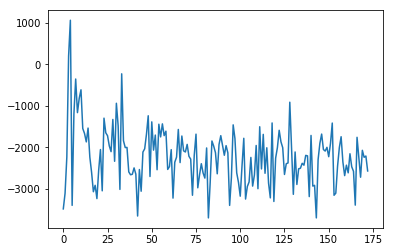

In [9]:
plt.plot(episode_rewards)
plt.show()

# Spot the bug!
It takes the agent a really long time to converge, and I suspect theres a bug in the code. Kindly help to spot the bug :)